<a href="https://www.kaggle.com/code/kenny3s/resnet50?scriptVersionId=159822919" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from fastai.vision.all import *
import torchvision
path=Path("/kaggle/input/lfw-yyy2-lbq")
files=get_image_files(path)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(get_image_files(path/l)) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same
    
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, parent_label, splits)
tls = TfmdLists(files, tfm, splits=splits)

def halftone(img):
    if isinstance(img, PILImage):
        img1=img.convert("1").convert("L")
        return img1
    else:
        return img
    
def gray(img):
    if isinstance(img, PILImage):
        img1=img.convert("L")
        return img1
    else:
        return img
    
workers = min(8, num_cpus())
dls = tls.dataloaders(after_item=[Resize(224), ToTensor, halftone], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                     num_workers=workers,bs=48)

#*aug_transforms()
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    def forward(self, x1, x2):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x1 = self.head(x1)
        x2 = self.head(x2)
        return x1, x2

In [3]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

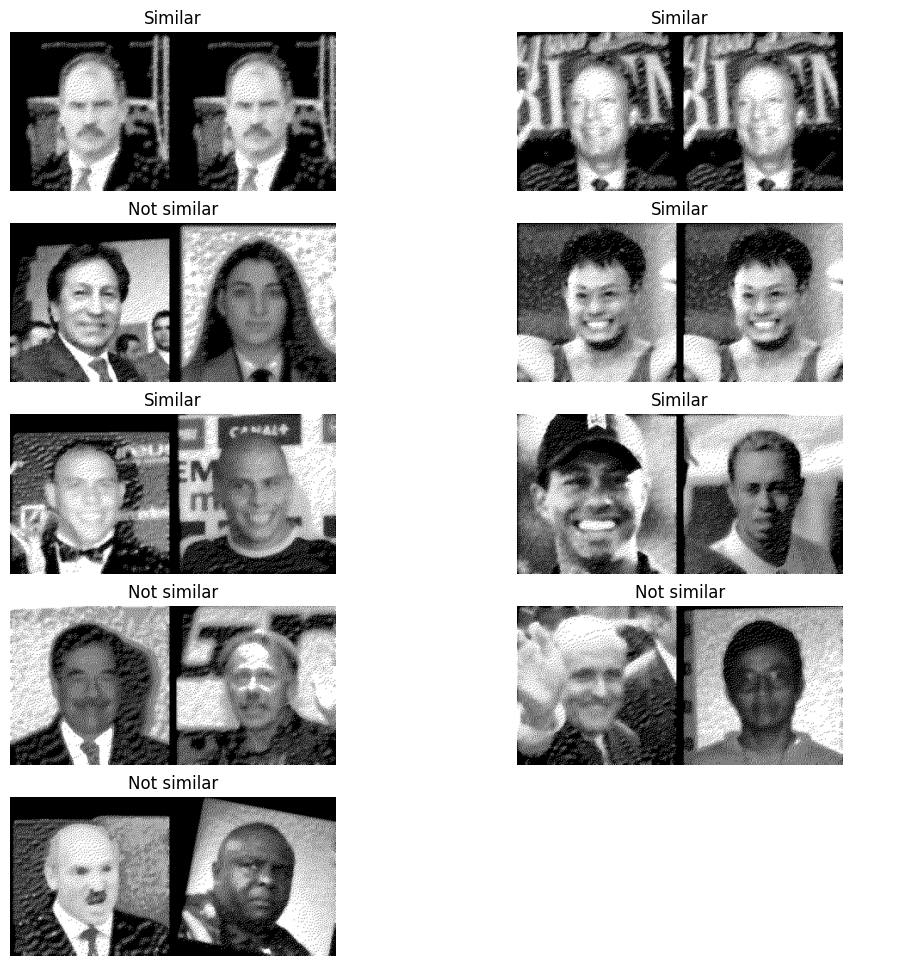

In [4]:
dls.show_batch()

In [5]:
from torchvision.models import list_models
# List available models
all_models = list_models()
classification_models = list_models(module=torchvision.models)
classification_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [6]:
EffNet=efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:05<00:00, 15.7MB/s]


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(EffNet, cut=-2)
head = create_head(1280, 256, [1024, 512], 0.5, bn_final=True)
model = SiameseModel(encoder, head)

In [8]:
from fastai.optimizer import Adam
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist * target
        ndist = dist * (~target)
        loss = 0.5 * ((pdist**2) + (F.relu(self.margin - ndist)**2))
        loss = loss.mean() if size_average else loss.sum()
        return loss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]
           

def contrastive_accuracy(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold).float()
    return (preds == targets).float().mean()

def accuracy(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    true_negatives = torch.sum((preds == 0) & (targets == 0)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0.0

    return accuracy

def precision(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0

    return precision

def recall(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    return recall

def f1_score(ops, targets):
    op1, op2 = ops[0], ops[1]
    dists = F.pairwise_distance(op1, op2)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1_score

class OptimalThreshold:
    def __init__(self, start=0.1, end=4.0, step=0.01):
        self.start = start
        self.end = end
        self.step = step
        self.best_threshold = None

    def find(self, preds, targets):
        best_accuracy = 0.0
        for threshold in np.arange(self.start, self.end, self.step):
            preds_thresholded = (preds < threshold).float()
            accuracy = (preds_thresholded == targets).float().mean()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.best_threshold = threshold
                
class PrintBestThreshold(Callback):
    def after_epoch(self):
        print(f"Epoch {self.learn.epoch} LR:{self.opt.hypers[0]['lr']:.10f} Best threshold: {optimal_threshold.best_threshold:.2f}")

optimal_threshold = OptimalThreshold()

learn = Learner(dls, model, loss_func=ContrastiveLoss(margin=2.5), opt_func=Adam,
                splitter=siamese_splitter, metrics=[accuracy, precision, recall, f1_score],cbs=PrintBestThreshold())

SuggestedLRs(valley=0.02290867641568184)

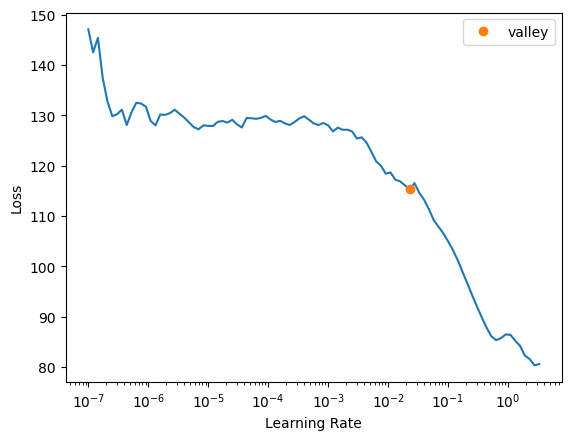

In [9]:
learn.lr_find()

In [10]:
learn.freeze()
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,49.097466,42.350090,0.769841,0.962147,0.554411,0.693043,02:04
1,6.332924,2.549589,0.783825,0.866370,0.693830,0.747730,02:03
2,2.266485,2.103893,0.799698,0.901347,0.688079,0.759394,02:02
3,2.184809,2.063664,0.802343,0.896927,0.690707,0.763397,02:02
4,2.102534,2.003747,0.815193,0.895138,0.720092,0.780691,02:02
5,2.112881,1.959754,0.837491,0.905338,0.758447,0.813964,02:02
6,2.033176,1.915450,0.852230,0.900606,0.793182,0.834001,02:03
7,2.023076,1.913314,0.855253,0.898189,0.802633,0.841311,02:02
8,2.010561,1.903847,0.859788,0.897410,0.810590,0.846469,02:03
9,1.990967,1.896039,0.863946,0.897209,0.819835,0.851421,02:02


Epoch 0 LR:0.0036906673 Best threshold: 3.33
Epoch 1 LR:0.0090671028 Best threshold: 0.18
Epoch 2 LR:0.0098927095 Best threshold: 0.33
Epoch 3 LR:0.0090506828 Best threshold: 1.21
Epoch 4 LR:0.0075082648 Best threshold: 0.53
Epoch 5 LR:0.0055321534 Best threshold: 0.42
Epoch 6 LR:0.0034640377 Best threshold: 1.23
Epoch 7 LR:0.0016615109 Best threshold: 0.31
Epoch 8 LR:0.0004362491 Best threshold: 1.24
Epoch 9 LR:0.0000001091 Best threshold: 1.72


In [11]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,1.958251,1.896188,0.862434,0.907592,0.804418,0.847402,02:45
1,1.960275,1.887490,0.867725,0.899668,0.827010,0.856398,02:45
2,1.944565,1.872704,0.873016,0.904655,0.834064,0.862830,02:45
3,1.983572,1.864898,0.880197,0.914078,0.836514,0.869649,02:45
4,1.918281,1.850091,0.885110,0.911496,0.851354,0.876049,02:45
5,1.934708,1.838022,0.890779,0.927016,0.847792,0.880309,02:45
6,1.957305,1.825043,0.897959,0.913604,0.877341,0.891510,02:46
7,1.899992,1.810028,0.902494,0.922640,0.877726,0.895545,02:45
8,1.935928,1.811178,0.905896,0.924321,0.882972,0.899932,02:45
9,1.886754,1.800585,0.906274,0.928557,0.878734,0.899432,02:45


Epoch 0 LR:0.0000013087 Best threshold: 1.58
Epoch 1 LR:0.0000037037 Best threshold: 1.67
Epoch 2 LR:0.0000066702 Best threshold: 1.64
Epoch 3 LR:0.0000090752 Best threshold: 1.70
Epoch 4 LR:0.0000100000 Best threshold: 1.92
Epoch 5 LR:0.0000098917 Best threshold: 0.76
Epoch 6 LR:0.0000095697 Best threshold: 0.71
Epoch 7 LR:0.0000090479 Best threshold: 0.81
Epoch 8 LR:0.0000083492 Best threshold: 1.35
Epoch 9 LR:0.0000075041 Best threshold: 1.72
Epoch 10 LR:0.0000065496 Best threshold: 1.46
Epoch 11 LR:0.0000055274 Best threshold: 1.41
Epoch 12 LR:0.0000044821 Best threshold: 1.21
Epoch 13 LR:0.0000034595 Best threshold: 1.24
Epoch 14 LR:0.0000025042 Best threshold: 1.06
Epoch 15 LR:0.0000016580 Best threshold: 0.98
Epoch 16 LR:0.0000009578 Best threshold: 0.89
Epoch 17 LR:0.0000004343 Best threshold: 0.85
Epoch 18 LR:0.0000001104 Best threshold: 0.91
Epoch 19 LR:0.0000000001 Best threshold: 0.88


In [12]:
learn.export('EffNet_V2_S_nExt_Filtter_256Emb.pkl')
#learn = load_learner('resnet50_lfw_gray.pkl', cpu=False)